In [4]:

import os
import sys
import pickle
import warnings
import time
import logging
import glob

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import ticker
from matplotlib.legend import Legend


from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')

In [29]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    priority_vl = 2 if LL == 512 else 3
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = priority_vl, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3 if priority_vl == 2 else 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

LL = 1024
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False

In [7]:
def_arr.shape

(181, 22, 10)

In [51]:
N = -1
def_arr = ad.get_arrays_full(Ndataset=N)[0]
act_list = ad.act_list[N]
conv_list = ad.conv_list[N] 
#def_arr_series = pd.DataFrame(def_arr[:,10,0], columns=['defect_density'])
#pd.plotting.lag_plot(def_arr_series, lag=40);

In [21]:
# extracting only the temperature values
values = pd.DataFrame(def_arr_series.values)
 
# using shift function to shift the values.
dataframe = pd.concat([values.shift(3), values.shift(2),
                       values.shift(1), values], axis=1)
# naming the columns
dataframe.columns = ['t', 't+1', 't+2', 't+3']
 
# using corr() function to compute the correlation
result = dataframe.corr()
 
print(result)

            t       t+1       t+2       t+3
t    1.000000  0.841171  0.754555  0.659560
t+1  0.841171  1.000000  0.841473  0.755038
t+2  0.754555  0.841473  1.000000  0.841875
t+3  0.659560  0.755038  0.841875  1.000000


In [67]:
from statsmodels.tsa.stattools import acf
act_idx = -2
acf_arr, confint, qstat, pvals = acf(def_arr[conv_list[act_idx]:,act_idx,0], nlags=500, qstat=True, alpha=0.05)

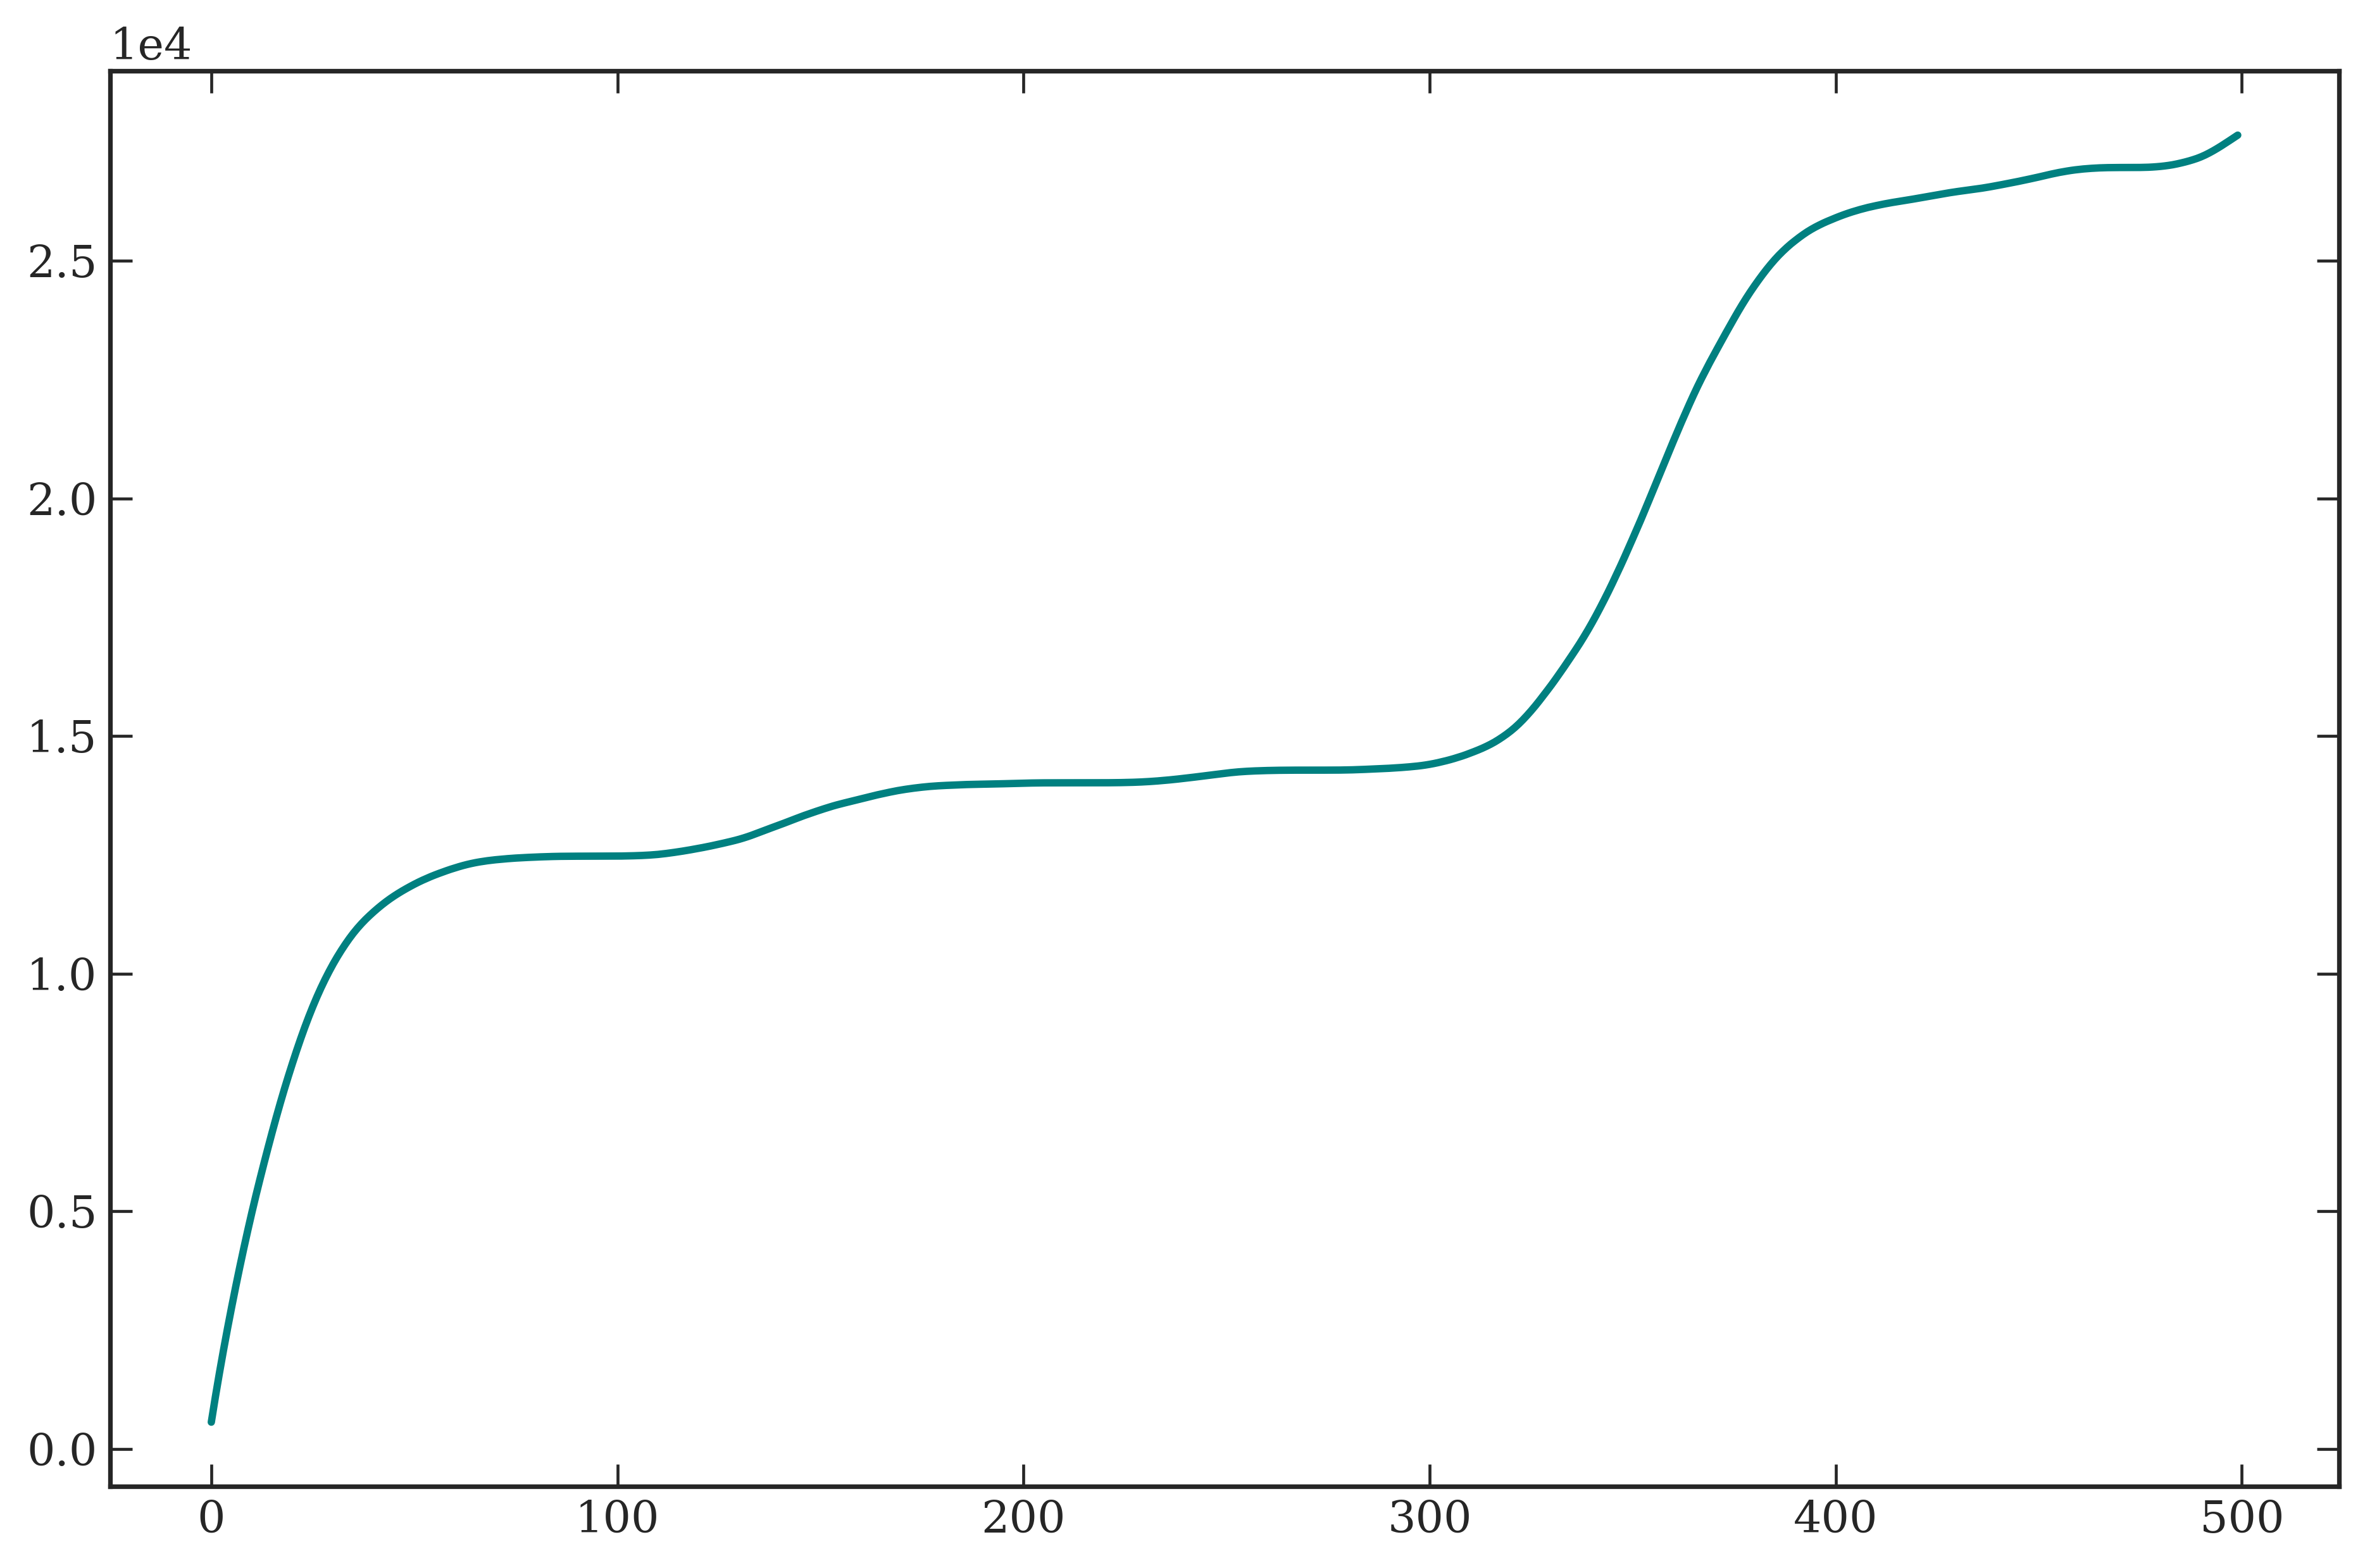

In [62]:
plt.plot(qstat)

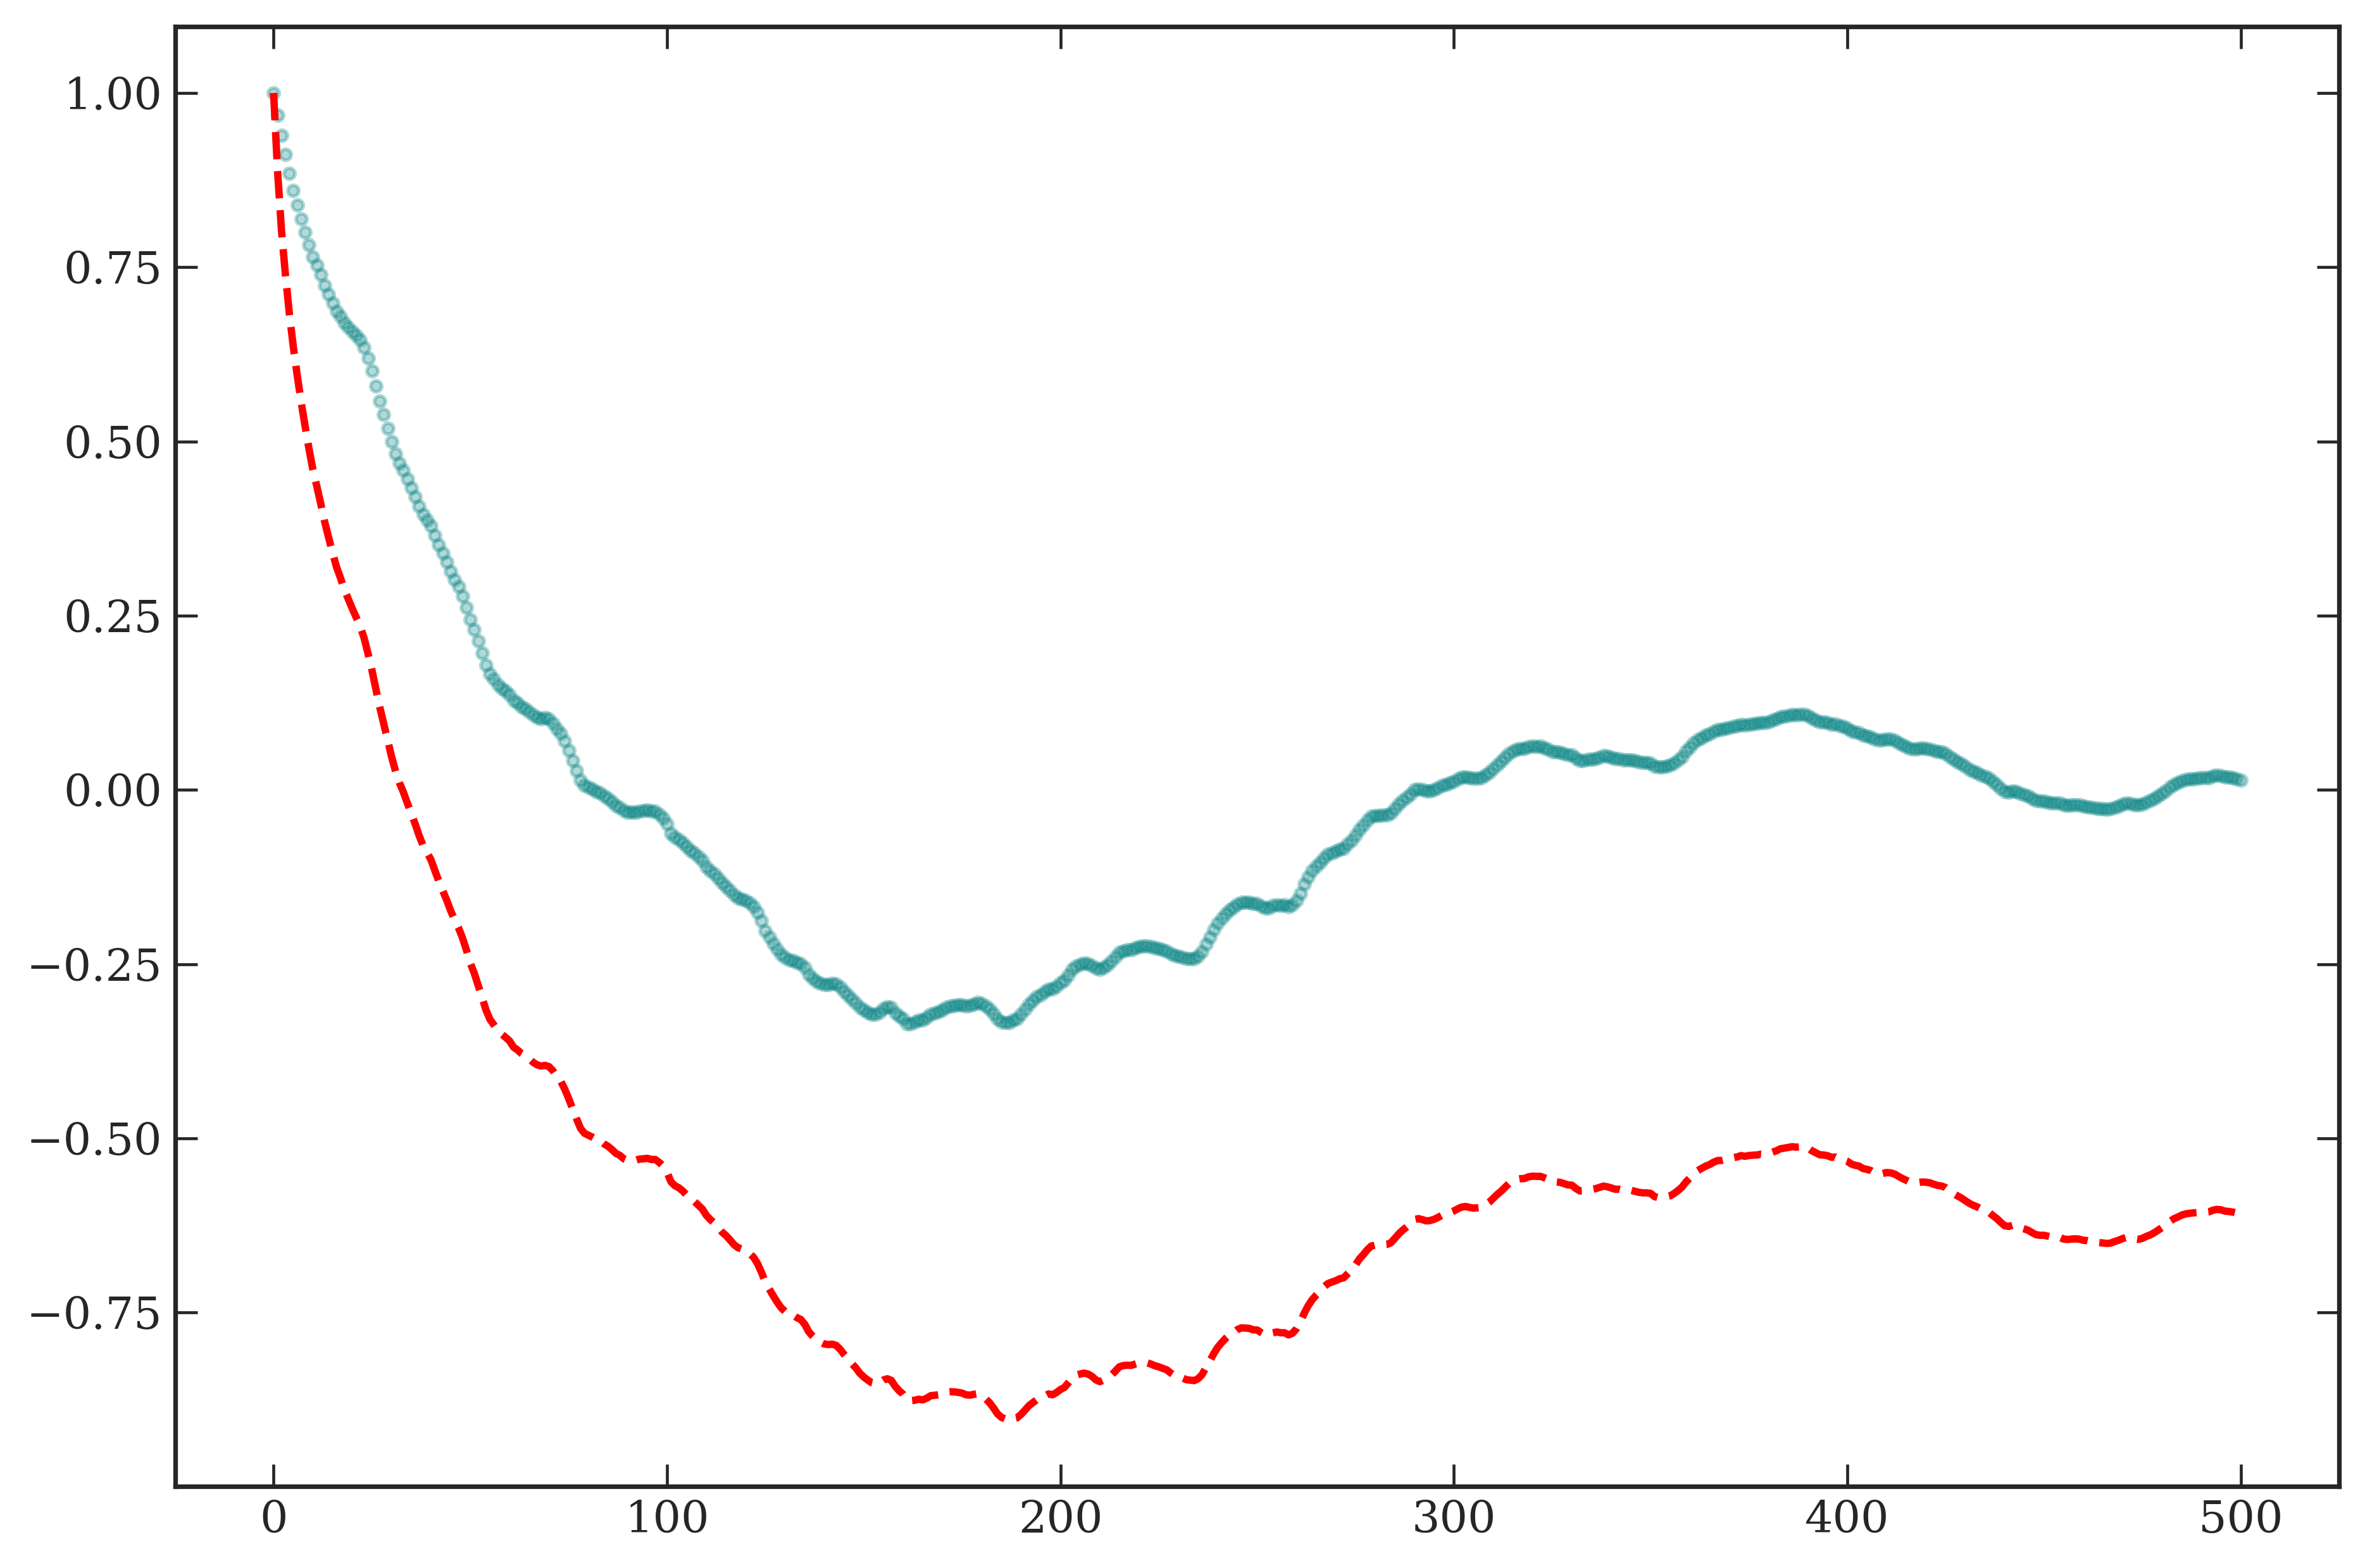

In [68]:
plt.plot(acf_arr, '.', alpha=.3)
plt.plot(confint[:,0], 'r--')

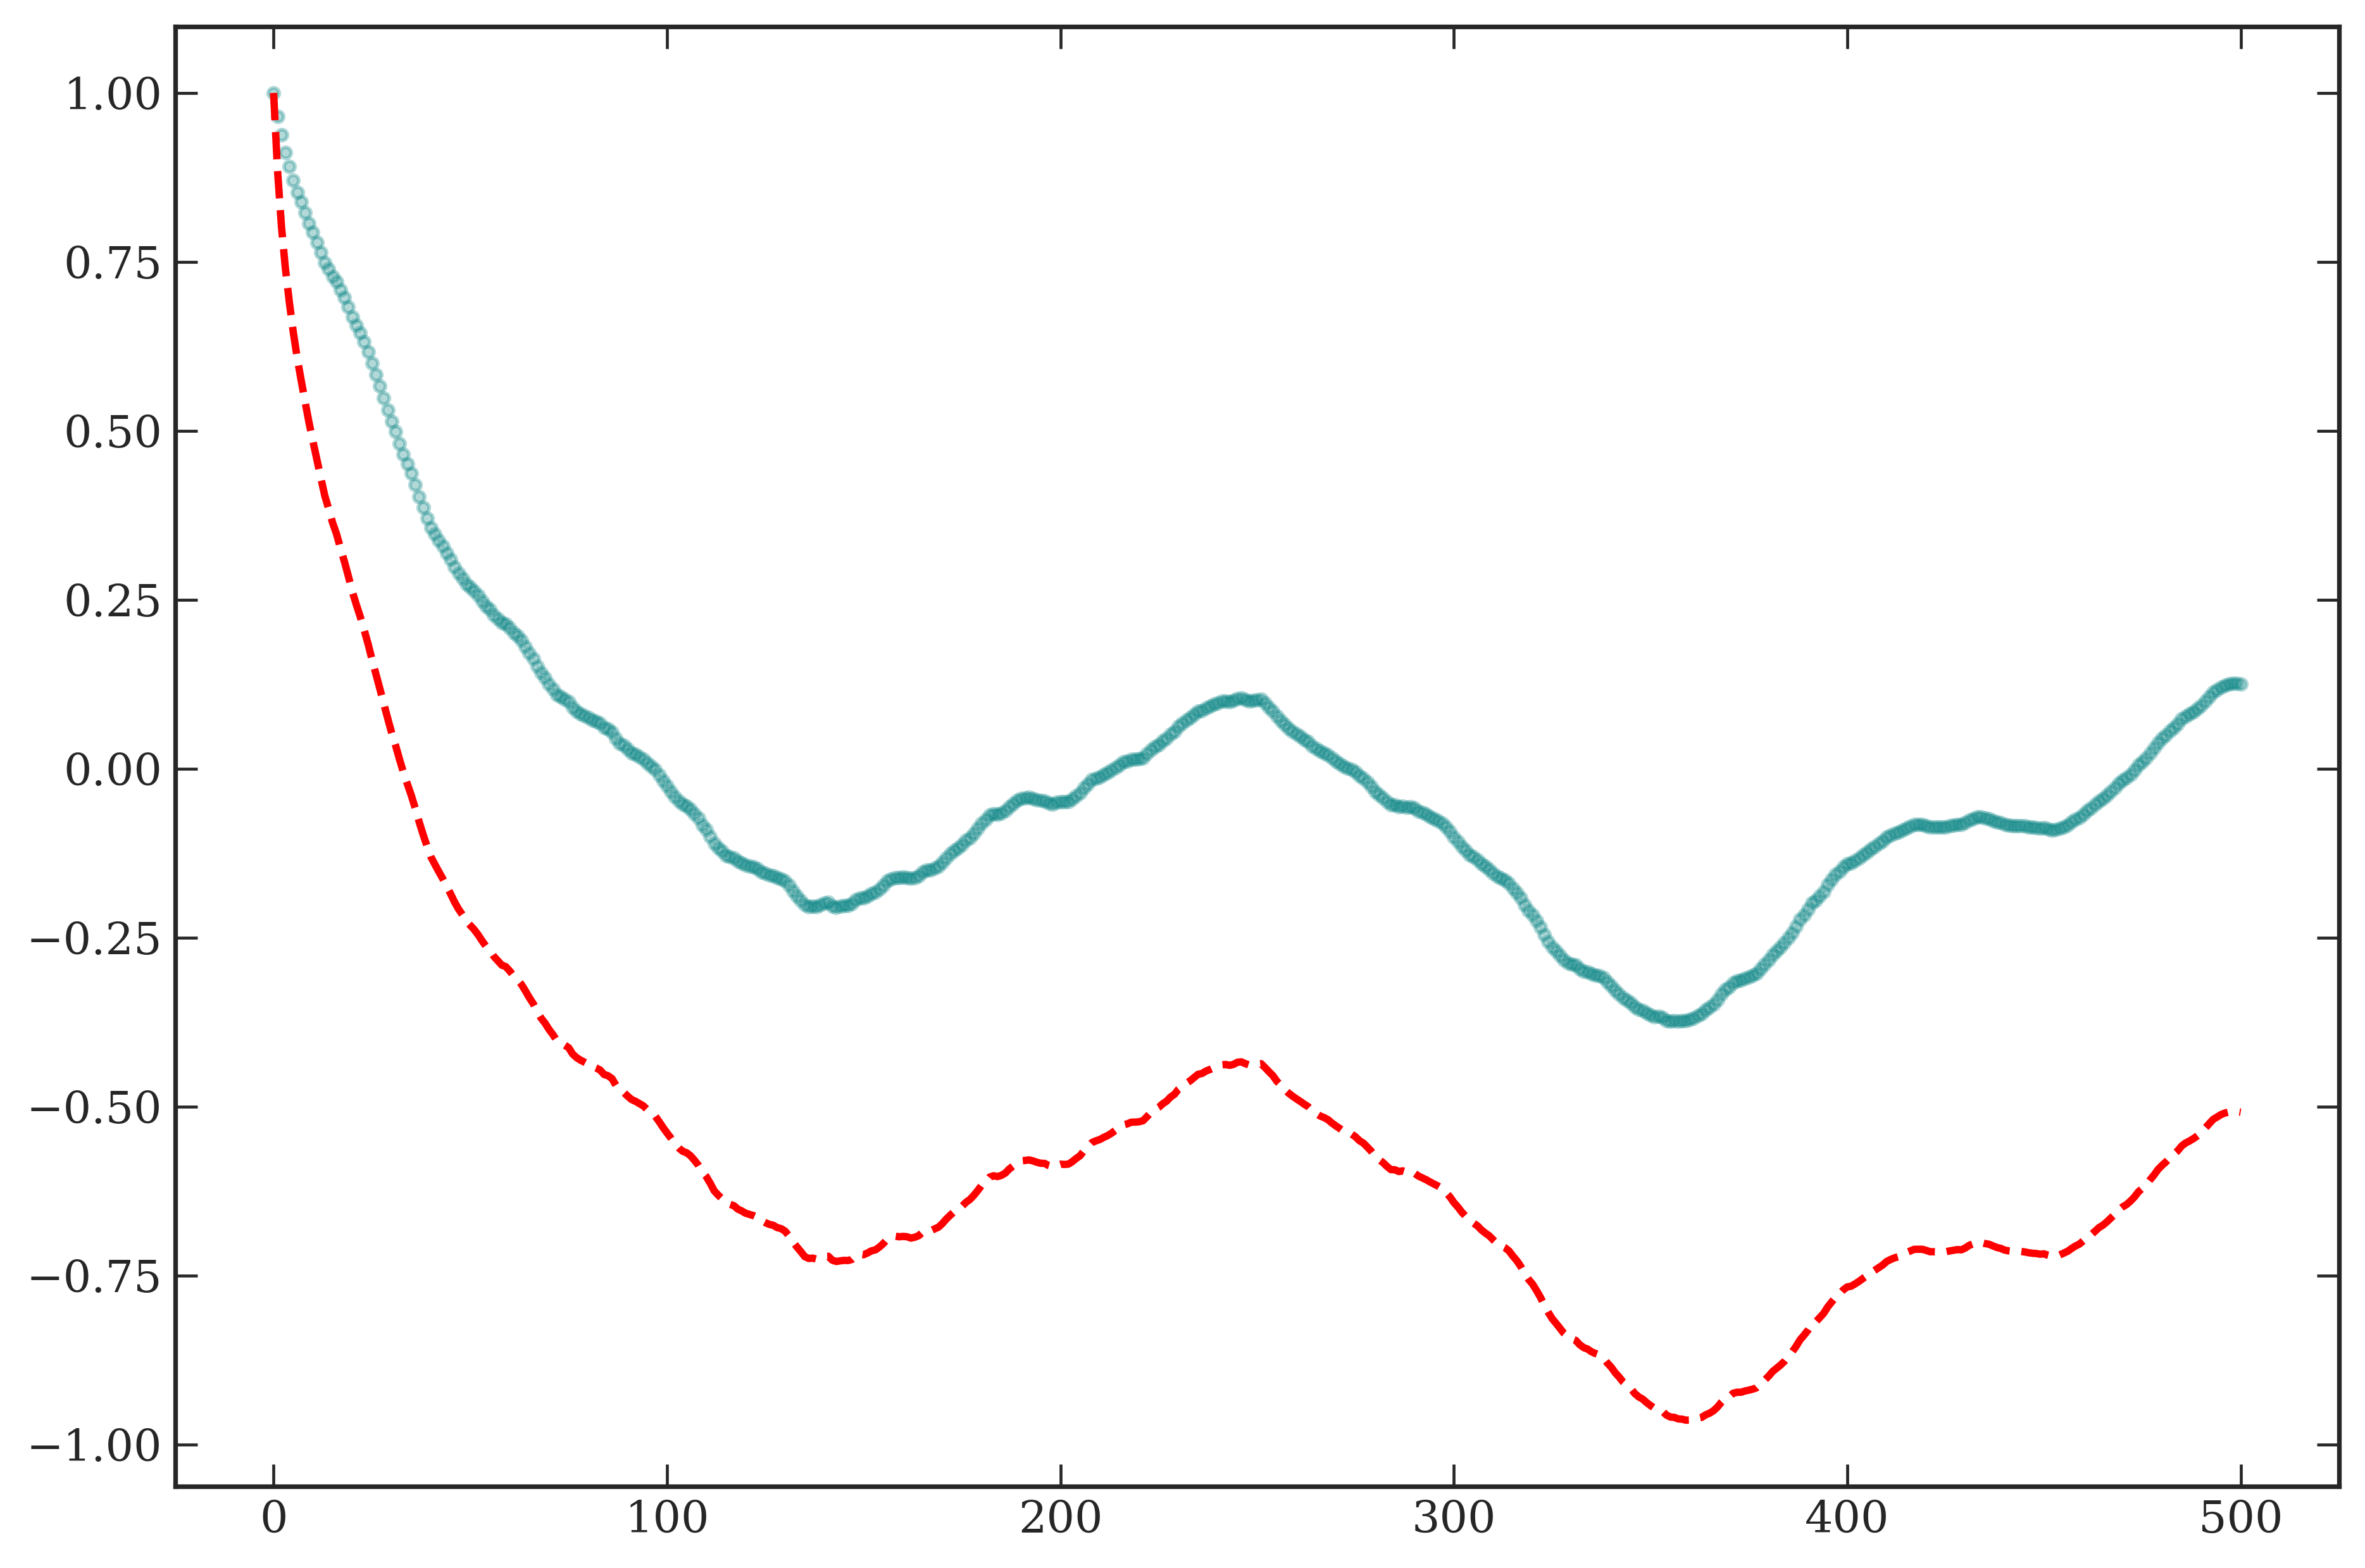

In [59]:
plt.plot(acf_arr, '.', alpha=.3)
plt.plot(confint[:,0], 'r--')

In [43]:
acf_arr.shape, confint.shape, qstat.shape, pvals.shape

((201,), (201, 2), (200,), (200,))

In [63]:
ad.Nexp

[10, 20, 20]

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

for i, exp in enumerate(range()):
    plot_acf(np.nanmean(def_arr[1100:,i,:], axis=-1), ax=ax[i], fft=True, lags=200, alpha = 0.05, use_vlines=True, title = '', label =f'act = {act}',);
    ax[i].legend();

In [69]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

for i, act in enumerate(act_list):
    plot_acf(np.nanmean(def_arr[0:,i,:], axis=-1), ax=ax[i], fft=True, lags=200, alpha = 0.05, use_vlines=True, title = '', label =f'act = {act}',);
    ax[i].legend();

In [54]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

for i, act in enumerate(act_list):
    plot_acf(np.nanmean(def_arr[conv_list[i]:,i,:], axis=-1), ax=ax[i], fft=True, lags=200, alpha = 0.05, use_vlines=True, title = '', label =f'act = {act}',);
    ax[i].legend();


In [ ]:
def calc_autocorr(x, axis = 0, conv_list = None):

    conv_list = x.shape[1] * [0] if conv_list is None else conv_list

    x_av = np.nan * np.zeros(x.shape[1])
    auto_corr = np.nan * np.zeros_like(x)

    for i in range(x.shape[1]):
        x_av[i] = np.nanmean(x[conv_list[i]:,i])
        X = x[conv_list[i]:,i] - x_av[i]
        auto_corr[:,i] = np.correlate(X, X, mode='full') / np.sum(X[:]**2)

    X = (x - x_av) 

  # result = np.correlate(x - av, x - av, mode='full') / var ## np.nansum((x)**2)
    result = np.correlate(X, X, mode='full') / np.sum(X[:]**2)
    return result[result.size // 2:] #/ normalization

def calc_autocorr(x,conv_list = None):

    conv_list = x.shape[1] * [0] if conv_list is None else conv_list

    x_av = np.nan * np.zeros(x.shape[1])
    auto_corr = np.nan * np.zeros_like(x)

    for i in range(x.shape[1]):
        x_av[i] = np.nanmean(x[conv_list[i]:,i])
        X = x[conv_list[i]:,i] - x_av[i]
        X_corr = np.correlate(X, X, mode='full') / np.sum(X[:]**2)
        X_corr = X_corr[X_corr.size // 2:]
        auto_corr[-X_corr.size:,i] = X_corr
    return auto_corr#[auto_corr.shape[0] // 2:] #/ normalization


In [ ]:
Ndataset_list = [0,-1] # [0,1, 2]
act_idx_bounds_list = [[6,None], [0,None]] #] [[11,-3], [-2,None], [0,None]]
fig, ax = plt.subplots(ncols=2, figsize=(16,12))
ax = ax.flatten()
for k, Ndataset in enumerate(Ndataset_list):
    defect_arr = ad.get_arrays_full(Ndataset=Ndataset)[0]
    conv_list = ad.conv_list[Ndataset]
  #  conv_list = defect_arr.shape[1] * [0]
    act_list = ad.act_list[Ndataset]
    auto_corr = np.zeros_like(defect_arr)
    Ndist = np.zeros(defect_arr.shape[1])
    lag = 10
    for i in range(defect_arr.shape[-1]):
        auto_corr[:, :, i] = calc_autocorr(defect_arr[:,:,i], conv_list)#np.apply_along_axis(calc_autocorr, axis = 0, arr = defect_arr[:, :, i])

   # fig, ax = plt.subplots(ncols=2, figsize=(16,12))
   # ax = ax.flatten()
    auto_corr_mean = np.nanmean(auto_corr, axis = -1)
    auto_corr_std = np.nanstd(auto_corr, axis=-1) / np.sqrt(defect_arr.shape[-1])
    Ndist 
    i0 = 0
    for i, act in enumerate(act_list[act_idx_bounds_list[k][0]:act_idx_bounds_list[k][1]]):
        i += i0
        ax[0].errorbar(act, auto_corr_mean[conv_list[i] + lag,i], auto_corr_std[conv_list[i] + lag,i], fmt='o', label=f'act = {act}')
        ax[1].errorbar(range(defect_arr.shape[0]),auto_corr_mean[:,i], auto_corr_std[:,i], label=f'act = {act}',alpha=.3)
        Ndist[i] = (1+2*(auto_corr_mean[conv_list[i] + 1:,i]**2).sum(axis=0))
    ax[1].legend(ncol=2,fontsize=12)
    ax[0].legend(ncol=2,fontsize=12)
    #Ndist = (1+2*(auto_corr_mean[1:,:]**2).sum(axis=0))
    Ndist, defect_arr.shape[0] * defect_arr.shape[-1] / Ndist
ax[0].set_xscale('log') 
ax[1].set_xscale('log')

In [ ]:
Ndataset=-1
defect_arr = ad.get_arrays_full(Ndataset=Ndataset)[0]
conv_list = ad.conv_list[Ndataset]
conv_list = defect_arr.shape[1] * [0]
act_list = ad.act_list[Ndataset]
auto_corr = np.zeros_like(defect_arr)
Ndist = np.zeros(defect_arr.shape[1])
lag = 1
for i in range(defect_arr.shape[-1]):
    auto_corr[:, :, i] = calc_autocorr(defect_arr[:,:,i], conv_list)#np.apply_along_axis(calc_autocorr, axis = 0, arr = defect_arr[:, :, i])

fig, ax = plt.subplots(ncols=2, figsize=(16,12))
ax = ax.flatten()
auto_corr_mean = np.nanmean(auto_corr, axis = -1)
auto_corr_std = np.nanstd(auto_corr, axis=-1) / np.sqrt(defect_arr.shape[-1])
Ndist 
i0 = 0
for i, act in enumerate(act_list[i0:]):
    i += i0
    ax[0].errorbar(act, auto_corr_mean[conv_list[i] + lag,i], auto_corr_std[conv_list[i] + lag,i], fmt='o', label=f'act = {act}')
    ax[1].errorbar(range(defect_arr.shape[0]),auto_corr_mean[:,i], auto_corr_std[:,i], label=f'act = {act}',alpha=.3)
    Ndist[i] = (1+2*(auto_corr_mean[conv_list[i] + 1:,i]**2).sum(axis=0))
ax[1].legend(ncol=2,fontsize=12)
ax[0].legend(ncol=2,fontsize=12)
#Ndist = (1+2*(auto_corr_mean[1:,:]**2).sum(axis=0))
Ndist, defect_arr.shape[0] * defect_arr.shape[-1] / Ndist

In [ ]:
Ndataset=-1
defect_arr = ad.get_arrays_full(Ndataset=Ndataset)[0]

act_list = ad.act_list[Ndataset]
auto_corr = np.zeros_like(defect_arr)
lag = 60
for i in range(defect_arr.shape[-1]):
    auto_corr[:, :, i] = np.apply_along_axis(calc_autocorr, axis = 0, arr = defect_arr[:, :, i])

fig, ax = plt.subplots(ncols=2, figsize=(16,12))
ax = ax.flatten()
auto_corr_mean = np.nanmean(auto_corr, axis = -1)
auto_corr_std = np.nanstd(auto_corr, axis=-1) / np.sqrt(defect_arr.shape[-1])
ax[0].errorbar(act_list, auto_corr_mean[lag], auto_corr_std[lag], fmt='.-')
for i, act in enumerate(act_list):
    ax[1].errorbar(range(defect_arr.shape[0]),auto_corr_mean[:,i], auto_corr_std[:,i], label=f'act = {act}',alpha=.3)
ax[1].legend(ncol=2,fontsize=12)
ax[0].legend(ncol=2,fontsize=12)
Ndist = (1+2*(auto_corr_mean[1:,:]**2).sum(axis=0))
Ndist, defect_arr.shape[0] * defect_arr.shape[-1] / Ndist